# Segmentation

In [1]:
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Constants

In [2]:
SEED = 5
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 50

NUM_TRAIN = 375
NUM_TRAIN = 94

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TRAIN // BATCH_SIZE_TEST

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_test = '../data/test'
data_dir_test_img = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

In [3]:
def create_segmentation_generator_train(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                     rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                     ,zoom_range=0.3
    )

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = img_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)


    #! do not perform data augmentation in the test generator
def create_segmentation_generator_test(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = img_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

In [4]:
train_generator = create_segmentation_generator_train(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

test_generator = create_segmentation_generator_test(data_dir_test_img, data_dir_test_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

Found 375 images belonging to 1 classes.
Found 375 images belonging to 1 classes.
Found 94 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


In [5]:
def display(display_list):
    plt.figure(figsize=(12,8))
    title = ['Input image', 'True Mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [6]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])


### Show trainig data

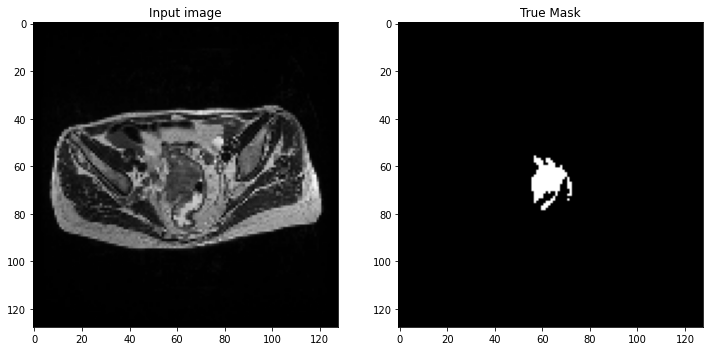

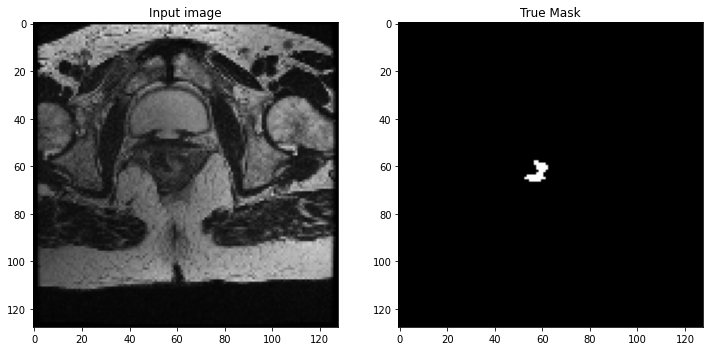

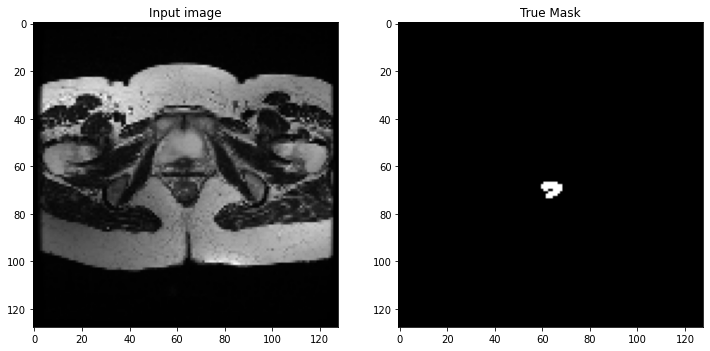

In [7]:
show_dataset(train_generator, 3) # training

### Show test data

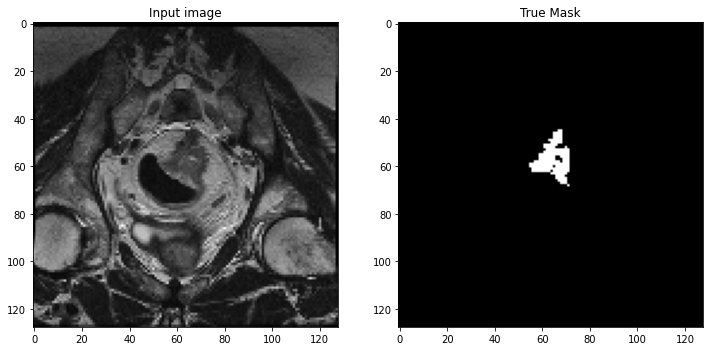

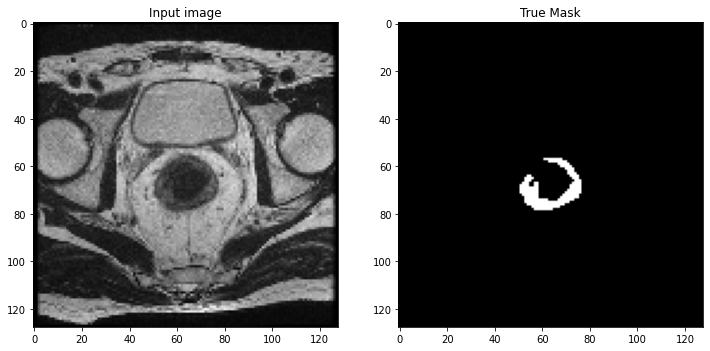

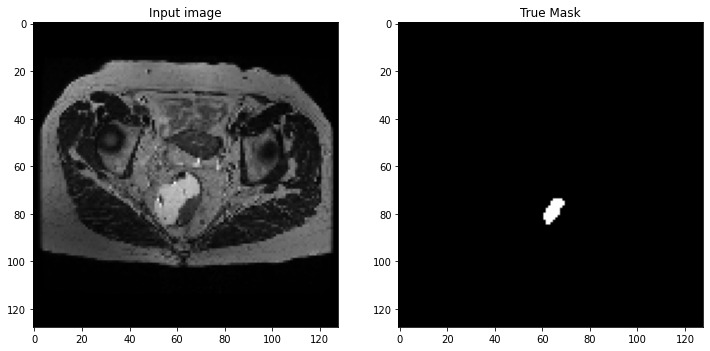

In [8]:
show_dataset(test_generator, 3) # test

## U-Net Model

In [9]:
def unet(n_levels, initial_features=64, n_conv=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = tf.keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = tf.keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = tf.keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [10]:
model = unet(4, 64)

metrics = [ 
    
    tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
        'accuracy'
           ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [11]:


callbacks = [

   tf.keras.callbacks.ModelCheckpoint('../data/models/' + model.name + "checkpoint.h5", save_best_only=True),
   #tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=test_generator, 
            validation_steps=EPOCH_STEP_TEST,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)



Epoch 1/50
23/23 [==============================] - 22s 930ms/step - loss: 0.4384 - binary_accuracy: 0.9111 - accuracy: 0.9111 - val_loss: 0.0574 - val_binary_accuracy: 0.9899 - val_accuracy: 0.9899
Epoch 2/50
23/23 [==============================] - 21s 925ms/step - loss: 0.0513 - binary_accuracy: 0.9900 - accuracy: 0.9900 - val_loss: 0.0582 - val_binary_accuracy: 0.9900 - val_accuracy: 0.9900
Epoch 3/50
23/23 [==============================] - 21s 928ms/step - loss: 0.0510 - binary_accuracy: 0.9901 - accuracy: 0.9901 - val_loss: 0.0494 - val_binary_accuracy: 0.9907 - val_accuracy: 0.9907
Epoch 4/50
23/23 [==============================] - 22s 945ms/step - loss: 0.0516 - binary_accuracy: 0.9887 - accuracy: 0.9887 - val_loss: 0.0462 - val_binary_accuracy: 0.9906 - val_accuracy: 0.9906
Epoch 5/50
23/23 [==============================] - 22s 949ms/step - loss: 0.0378 - binary_accuracy: 0.9914 - accuracy: 0.9914 - val_loss: 0.0494 - val_binary_accuracy: 0.9899 - val_accuracy: 0.9899
Epoch

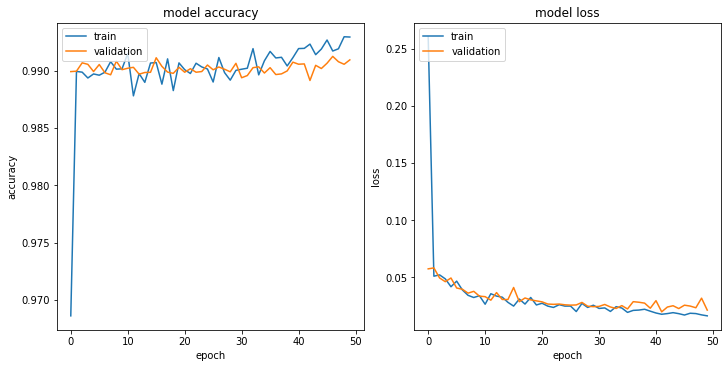

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='upper left')

plt.show()

In [18]:
model.save('../data/models/' + model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [13]:
test_generator = create_segmentation_generator_train(data_dir_test_img, data_dir_test_mask, 1, IMG_SIZE, SEED)

Found 94 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


In [16]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image) 
        display([image[0], mask[0], pred_mask[0]])

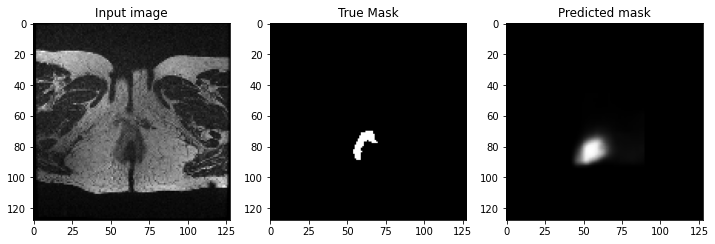

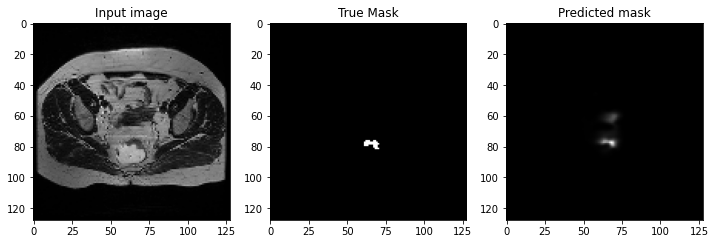

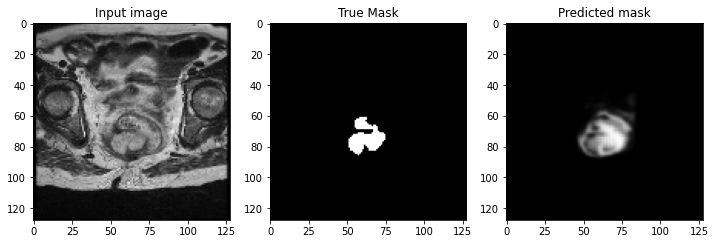

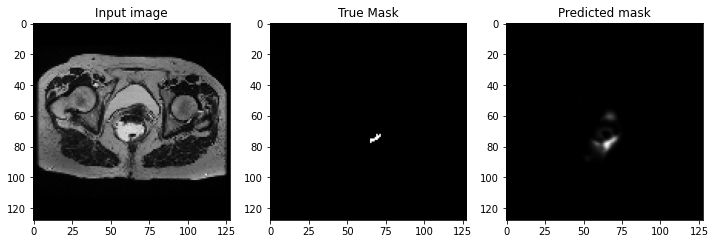

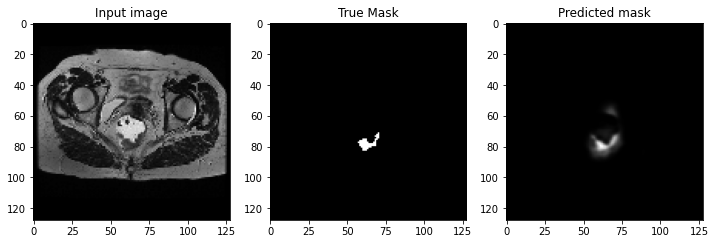

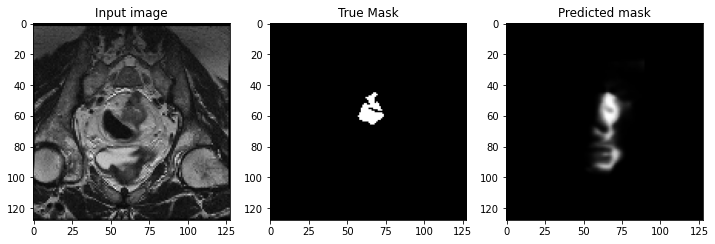

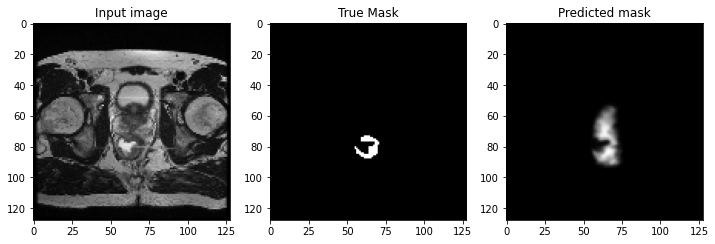

In [20]:
show_prediction(test_generator, 7)